In [1]:
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm import tqdm




/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_38003/1410265310.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
path = "/Users/annek/Documents/RACMO2.3p2"
pathGreenland5_5 = path + "/FGRN055"
pathrapid =  "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055"


In [15]:
!ls "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055"

BN_RACMO2.3p2_ERA5_3h_FGRN055 GIMP_DEM_90m
Downscaling_GR                RACMO2.4.1_historical


In [4]:
grid_size = "FGRN055"
downscaling_type = "BN_RACMO2.3p2_ERA5_3h_FGRN055"
time_resolution = "Annual"
year = "2018"
other_var = "NC_MD"

path_variables = os.path.join(path, grid_size, 
                              downscaling_type, time_resolution, 
                              other_var
                             )
print(path_variables)


/Users/annek/Documents/RACMO2.3p2/FGRN055/BN_RACMO2.3p2_ERA5_3h_FGRN055/Annual/NC_MD


In [5]:
listFiles = []
for name in os.listdir(os.path.join(path_variables)):
    listFiles.append(name)
listFiles = sorted(listFiles)
# Assuming listFiles is already populated with filenames
files_containing_2018_runoff = []

for filename in listFiles:
    if "2018" in filename and "runoff" in filename:
        files_containing_2018_runoff.append(filename)

print("Files containing '2018' and 'runoff':")
for file in files_containing_2018_runoff:
    print(file)

Files containing '2018' and 'runoff':
runoff.2018.FGRN055_BN_RACMO2.3p2_ERA5_3h_FGRN055.YY.nc


In [6]:
ds = xr.open_dataset(os.path.join(path_variables, file))

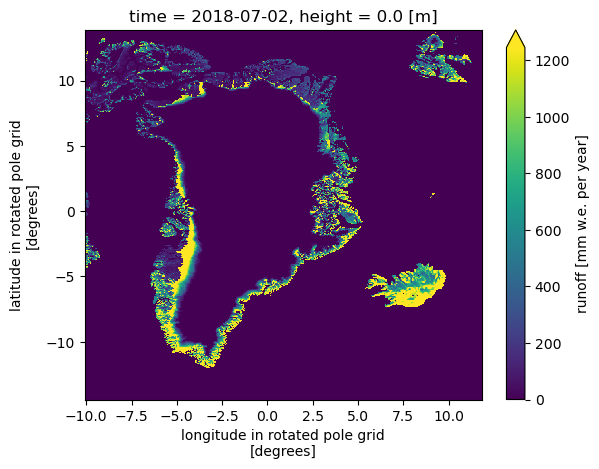

In [7]:
ds['runoff'].isel(time=0, height=0).plot(robust=True)

# open masks 

In [8]:
masks = path +"/FGRN055/BN_RACMO2.3p2_ERA5_3h_FGRN055/FGRN055_Masks.nc"
masks = xr.open_dataset(masks, engine='netcdf4')
masks.close()


In [9]:
masks
# make list of datavariables in masks
mask_vars = list(masks.data_vars)
mask_vars

['Icemask_noGR',
 'Icemask_GR',
 'X',
 'Y',
 'lon',
 'lat',
 'IceMask',
 'LSM',
 'Topography',
 'Geopotential',
 'Area',
 'BIA',
 'Promicemask',
 'GRACE_basins',
 'Mouginot_basins',
 'LSM_GR',
 'Grounded_ice',
 'Basins']

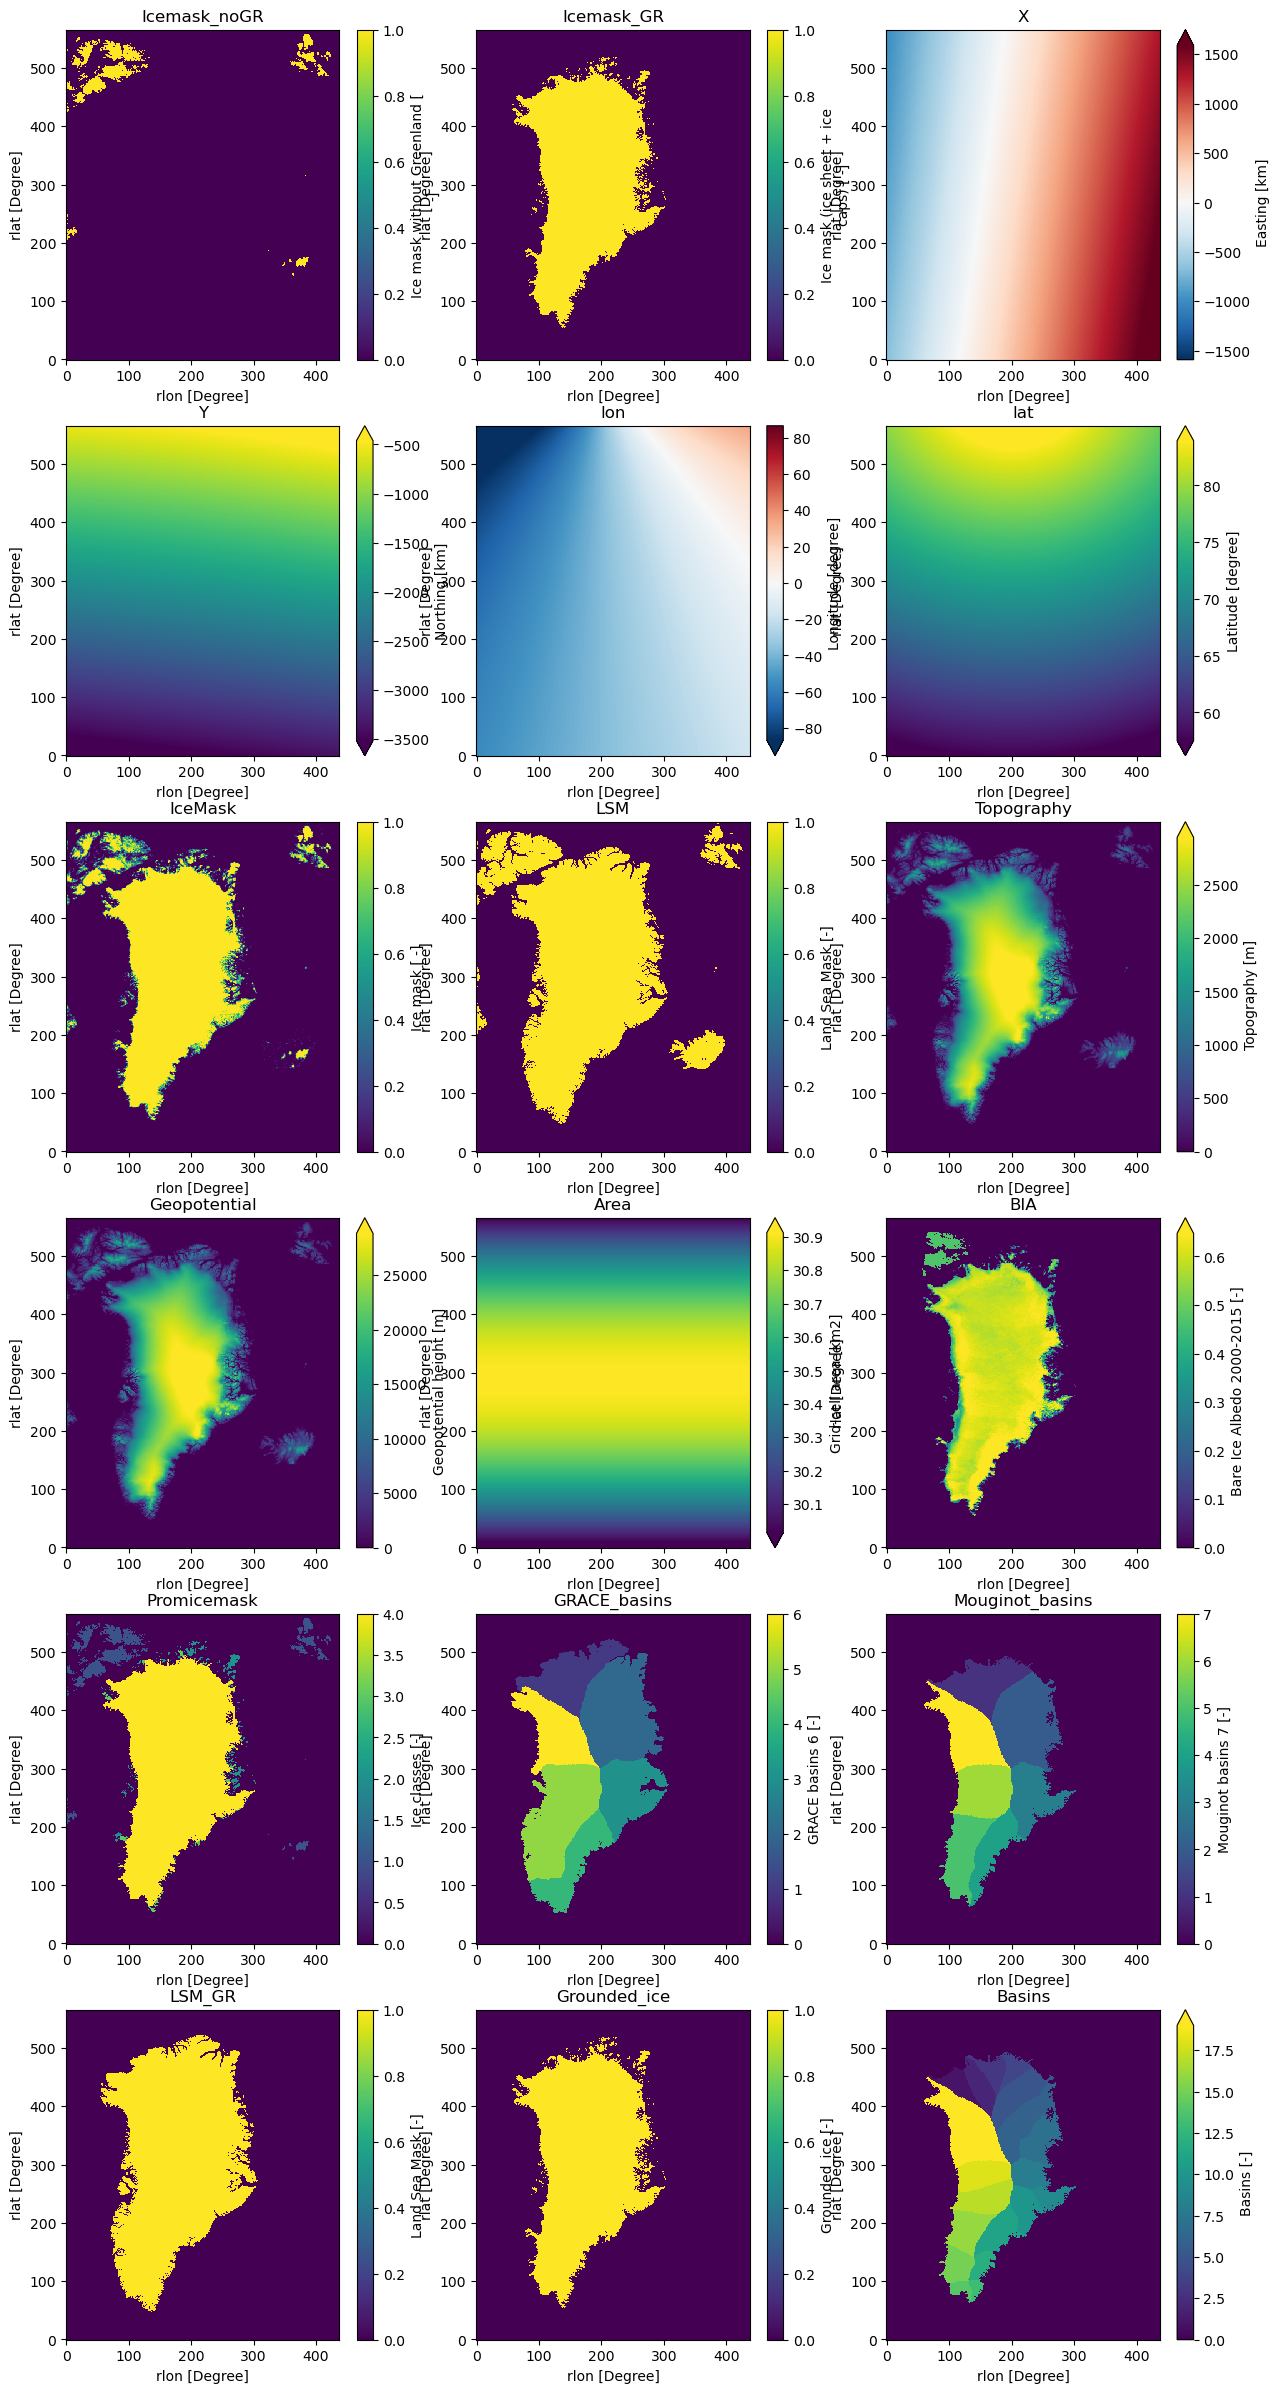

In [10]:
# plot all data variables in masks as a subplot
fig, axs = plt.subplots(6, 3, figsize=(15, 30))
for i, ax in enumerate(axs.flat):
    masks[mask_vars[i]].plot(ax=ax, robust=True)
    ax.set_title(mask_vars[i])

I find the LSM is Land-Sea Mask, 

Promice mask the following:

 (3 = GrIS, 1 and 2 = GICs peripheral ice caps) and topography from the GIMP DEM upscaled to 1 km.




In [11]:
print(masks['LSM_GR'])
print("\n")
print(masks['Promicemask'])


<xarray.DataArray 'LSM_GR' (rlat: 566, rlon: 438)>
[247908 values with dtype=float32]
Coordinates:
  * rlon     (rlon) float32 0.0 1.0 2.0 3.0 4.0 ... 434.0 435.0 436.0 437.0
  * rlat     (rlat) float32 0.0 1.0 2.0 3.0 4.0 ... 562.0 563.0 564.0 565.0
Attributes:
    units:          -
    long_name:      Land Sea Mask
    standard_name:  Land_Sea_Mask
    actual_range:   [0. 1.]


<xarray.DataArray 'Promicemask' (rlat: 566, rlon: 438)>
[247908 values with dtype=float32]
Coordinates:
  * rlon     (rlon) float32 0.0 1.0 2.0 3.0 4.0 ... 434.0 435.0 436.0 437.0
  * rlat     (rlat) float32 0.0 1.0 2.0 3.0 4.0 ... 562.0 563.0 564.0 565.0
Attributes:
    units:          -
    long_name:      Ice classes
    standard_name:  Ice_classes
    actual_range:   [0. 4.]


In [12]:
# can you select runoff for the promicemask == 3
# ds['runoff'].

GrIS_total = ds['runoff'].isel(time=0, height=0).where(masks['Promicemask'].values == 4).sum()
GrIS_total

<xarray.DataArray 'runoff' ()>
array(6965254.88964681)
Coordinates:
    time     datetime64[ns] 2018-07-02
    height   float64 0.0

In [13]:
spatial_resolution = 5.5e3 # m 5.5 km
surface_area_per_gridcell = spatial_resolution**2
mm_weq_to_km3 = 1e-3 * surface_area_per_gridcell/1e9



# open multiple datasets


In [17]:
# can you make a loop over listFiles and open them one by one and then combine them into a single dataset?
# Assuming listFiles is already populated with filenames
ds_list = []
for filename in listFiles:
    ds_single = xr.open_dataset(os.path.join(path_variables, filename))
    ds_list.append(ds_single)
dss = xr.concat(ds_list, dim='time')


ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [16]:
(dss.runoff.where(masks['Promicemask'].values == 4).sum(dim=['rlat', 'rlon'])*mm_weq_to_km3).plot(label='Promicemask, GrIS')
(dss.runoff.where(masks['Promicemask'].values == 3).sum(dim=['rlat', 'rlon'])*mm_weq_to_km3).plot(label='Promicemask, Ice caps')
(dss.runoff.where(masks['Promicemask'].values == 2).sum(dim=['rlat', 'rlon'])*mm_weq_to_km3).plot(label='Promicemask, Ice caps2')
# sum over all 
(dss.runoff.where(masks['Promicemask'].values >= 2).sum(dim=['rlat', 'rlon'])*mm_weq_to_km3).plot(label='Promicemask, Ice total')
plt.legend()

NameError: name 'dss' is not defined

In [18]:
# can you make directories wih names 1989 to 2023 in the folder "path_variables" 

for year in range(1989, 2024):
    os.makedirs(os.path.join(path_variables, str(year)), exist_ok=True)

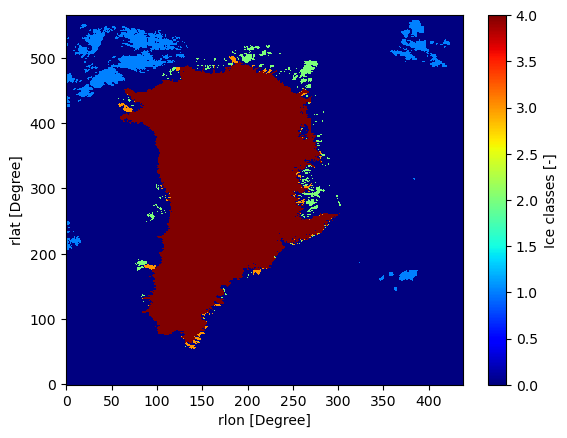

In [16]:
masks['Promicemask'].plot(cmap='jet')

# Monthly -->

In [19]:
grid_size = "FGRN055"
downscaling_type = "BN_RACMO2.3p2_ERA5_3h_FGRN055"
time_resolution = "Monthly"
year = "2010"
other_var = "NC_MD"

pathMonthly = os.path.join(path, grid_size, 
                              downscaling_type, time_resolution, year,
                              other_var
                             )
print(pathMonthly)

listFiles = []
for name in os.listdir(os.path.join(pathMonthly)):
    listFiles.append(name)
listFiles = sorted(listFiles)
# Assuming listFiles is already populated with filenames
files_containing_runoff = []

for filename in listFiles:
    if "runoff" in filename:
        files_containing_runoff.append(filename)

print("Files containing'runoff':")
for file in files_containing_runoff:
    print(file)

/Users/annek/Documents/RACMO2.3p2/FGRN055/BN_RACMO2.3p2_ERA5_3h_FGRN055/Monthly/2010/NC_MD
Files containing'runoff':
runoff.2010.FGRN055_BN_RACMO2.3p2_ERA5_3h_FGRN055.MM.nc


Total runoff in 2010 in km3
493.5877566946838


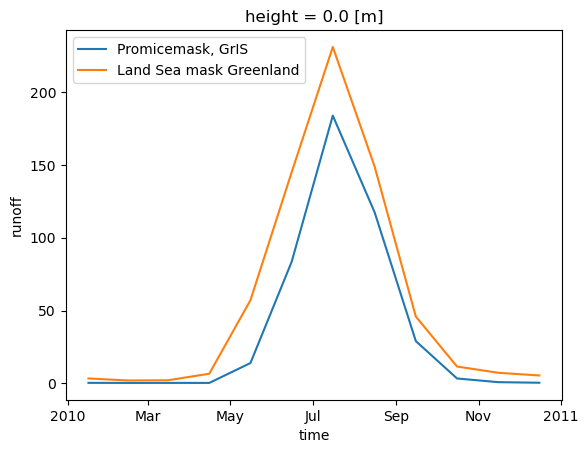

In [20]:
dsMonthly = xr.open_dataset(os.path.join(pathMonthly, file))
(dsMonthly['runoff'].where(masks['Promicemask'].values == 4).sum(dim=['rlat', 'rlon'])*mm_weq_to_km3).plot(label='Promicemask, GrIS')
plt.ylabel('Runoff (km3)')

print("Total runoff in 2010 in km3")
print((dsMonthly['runoff'].where(masks['Promicemask'].values >=2).sum()*mm_weq_to_km3).values)

# now sum over LSM_GR and add to the plot
(dsMonthly['runoff'].where(masks['LSM_GR'].values == 1).sum(dim=['rlat', 'rlon'])*mm_weq_to_km3).plot(label='Land Sea mask Greenland')
plt.legend()


# 1 km resolution

## masks

Land Sea Mask from Brice


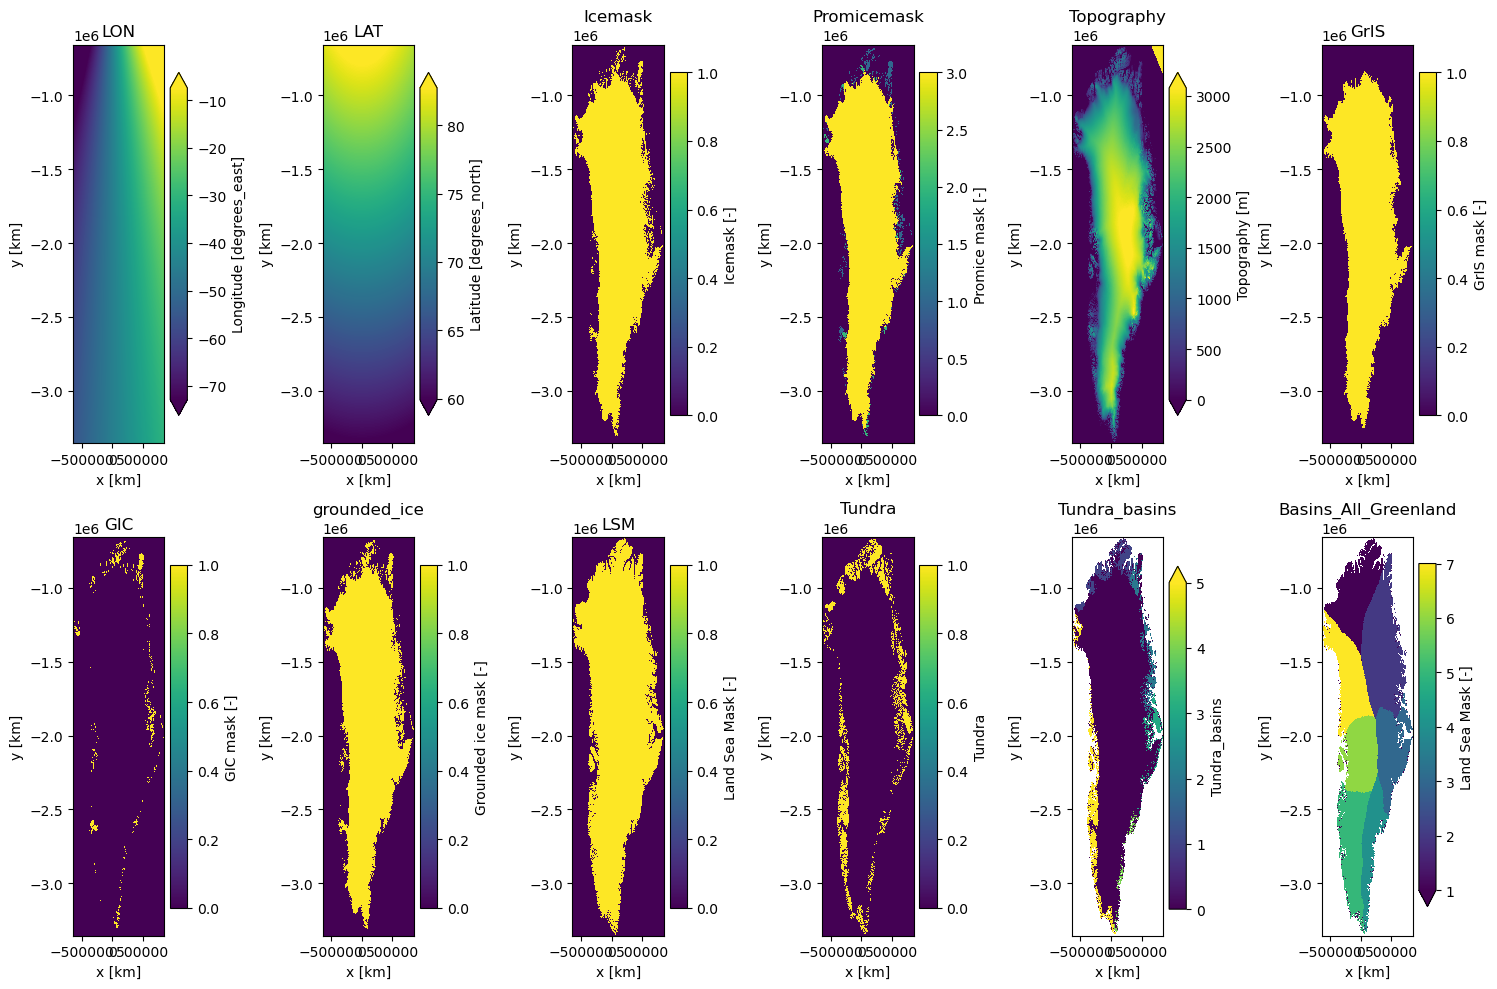

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
path_mask_1k_with_tundra = "/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/GrIS_topo_icemask_lsm_tundra_basins_lon_lat_1km.nc"
mask_1k_with_tundra = xr.open_dataset(path_mask_1k_with_tundra)

# make a fig with subplots of 3x3 with all variables in mask_1k_with_LSM
fig, axs = plt.subplots(2, 6, figsize=(15, 10))
for i, ax in enumerate(axs.flat):
    if i < len(list(mask_1k_with_tundra.data_vars)):
        mask_1k_with_tundra[list(mask_1k_with_tundra.data_vars)[i]].plot(ax=ax, robust=True)
        ax.set_title(list(mask_1k_with_tundra.data_vars)[i])

plt.tight_layout()


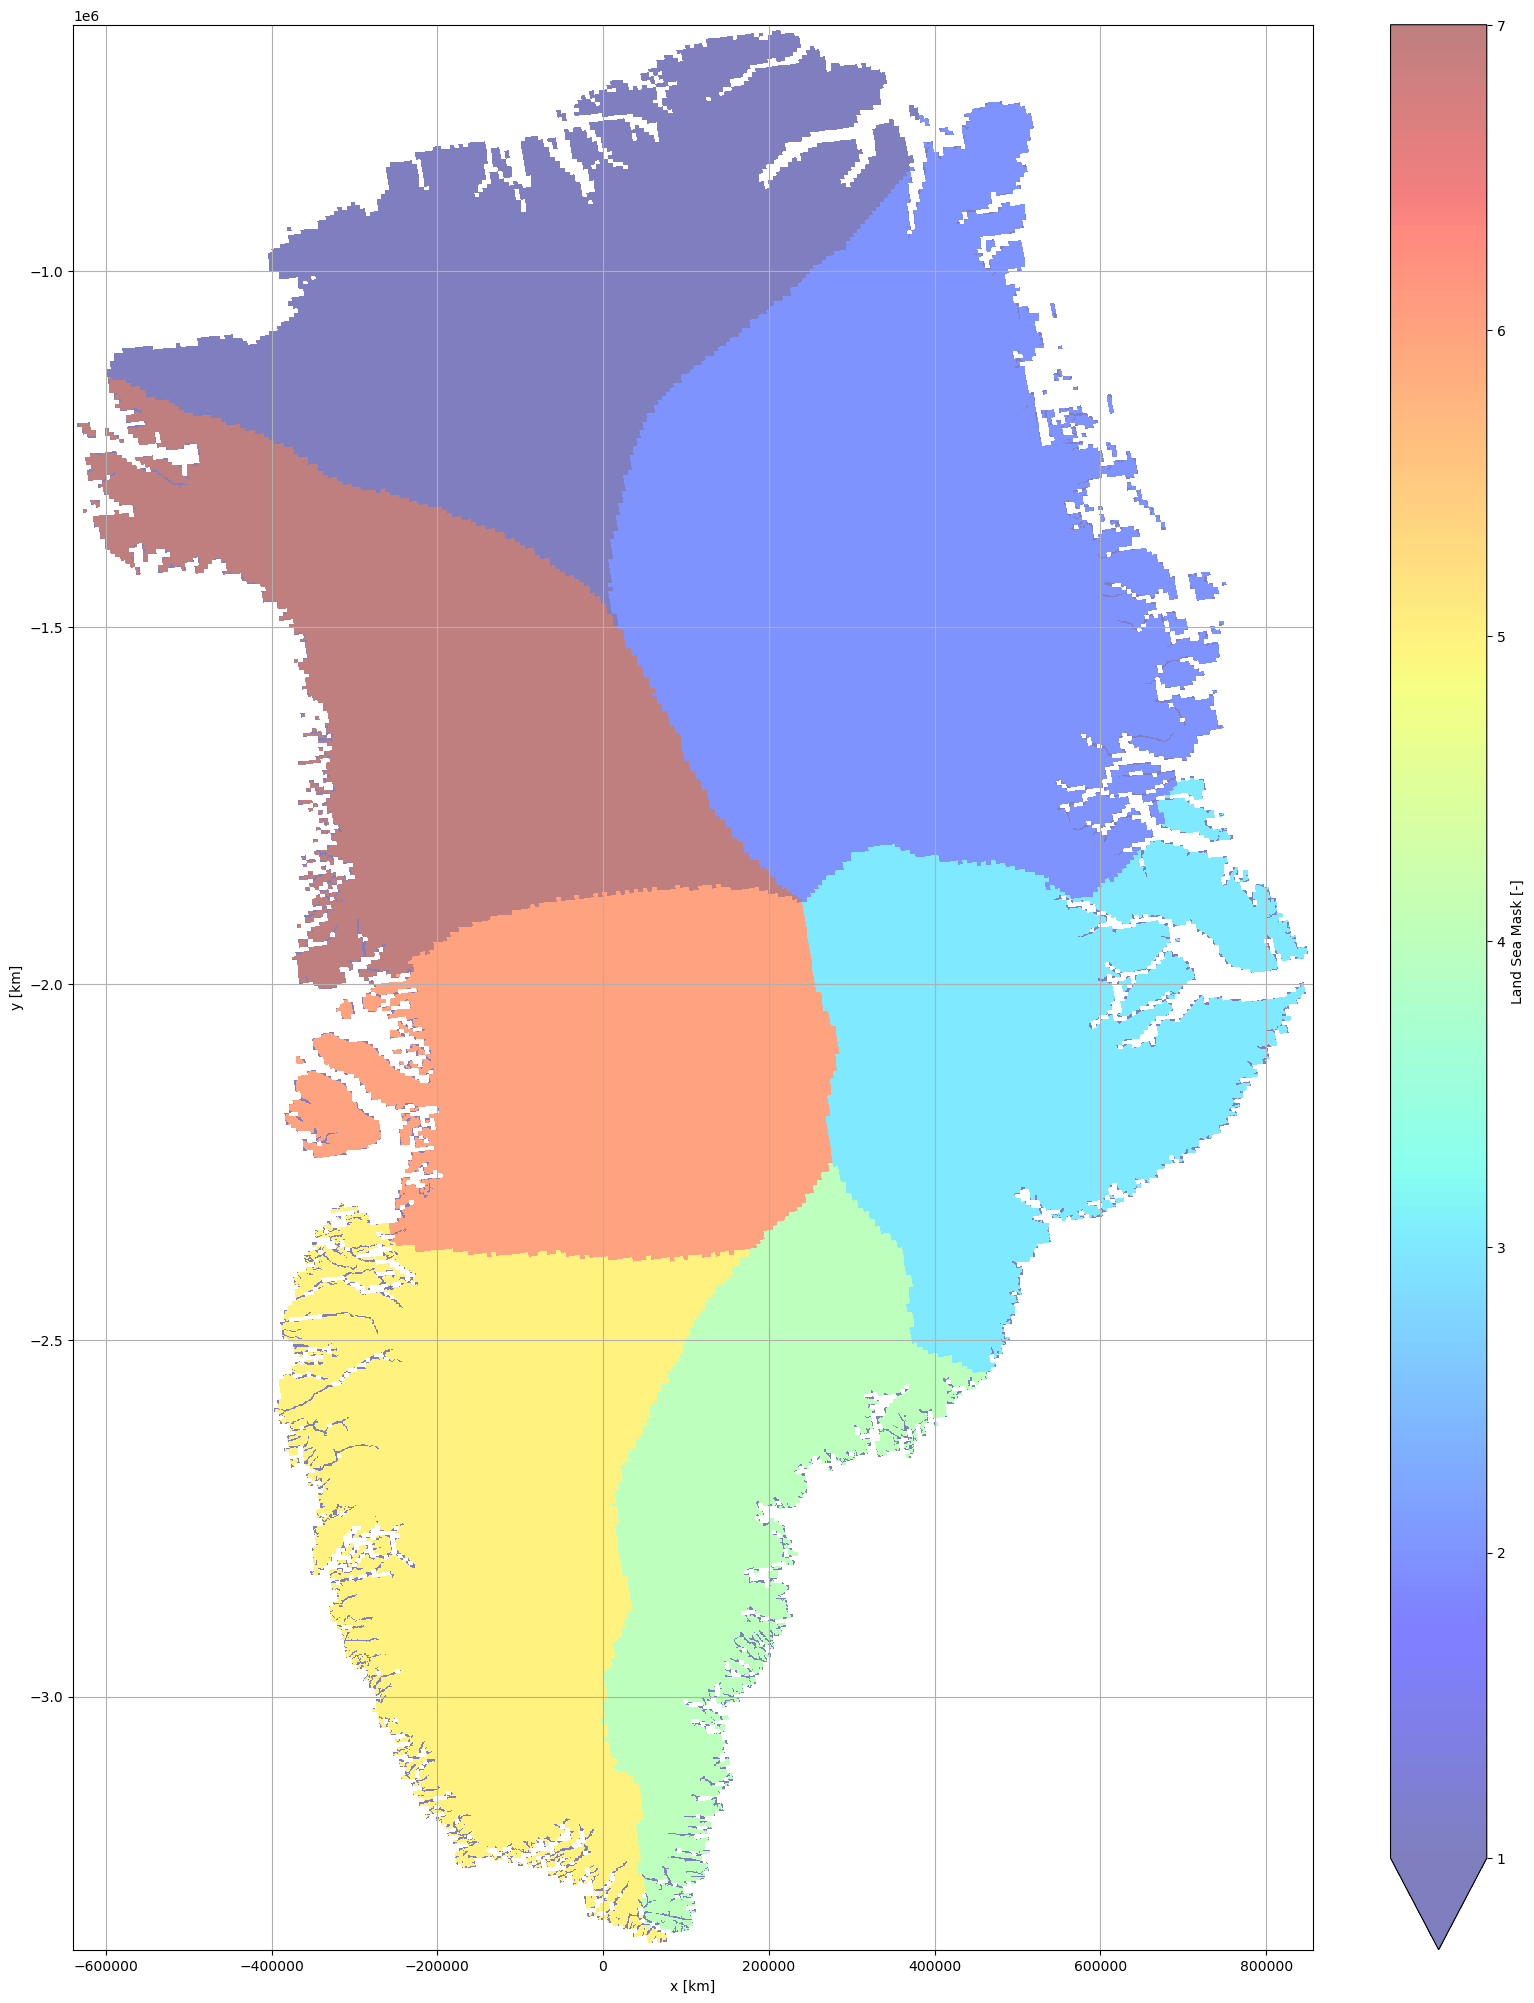

In [22]:
fig, ax = plt.subplots(figsize=(20, 25))
mask_1k_with_tundra['Basins_All_Greenland'].plot(robust=True, ax = ax, alpha=0.5, cmap='jet')

minx, maxx, miny, maxy = mask_1k_with_tundra.x.min(), mask_1k_with_tundra.x.max(), mask_1k_with_tundra.y.min(), mask_1k_with_tundra.y.max()


plt.grid()



In [55]:
y = mask_1k_with_tundra.y
x = mask_1k_with_tundra.x

border_CE_SE = (y>-2.55e6) & (x>0)
border_CE_NE = (y<-1.85e6)
border_CE = border_CE_SE & border_CE_NE

# SE
border_SE_SW = (x>5e4) 
border_SE_CE = (y<-2.55e6)
border_SE = border_SE_SW & border_SE_CE

# SW 
border_SW_CW = (y<-2.3e6) 
border_SW_SE =  (x<5e4)
border_SW = border_SW_CW & border_SW_SE

# CW
border_CW_NW = (y<-2e6) & (x<-2e5)
border_CW_SW = (y>-2.3e6) & (x<-2e5)
border_CW = border_CW_NW & border_CW_SW

# NW
border_NW_NO = (y<-1.15e6) & (x<-2e5)
border_NW_CW = (y>-2e6) & (x<-2e5)
border_NW = border_NW_NO & border_NW_CW


# North: 
border_NO_NW = (y>-1.15e6)  & (x <0)
border_NO_NE = (y>-0.85e6) & (x<3.5e5)
border_NO = border_NO_NW | border_NO_NE


# NE
border_NE_NO = (x>3.5e5) 
border_NE_CE = (y>-1.85e6) 
border_NE = border_NE_NO & border_NE_CE


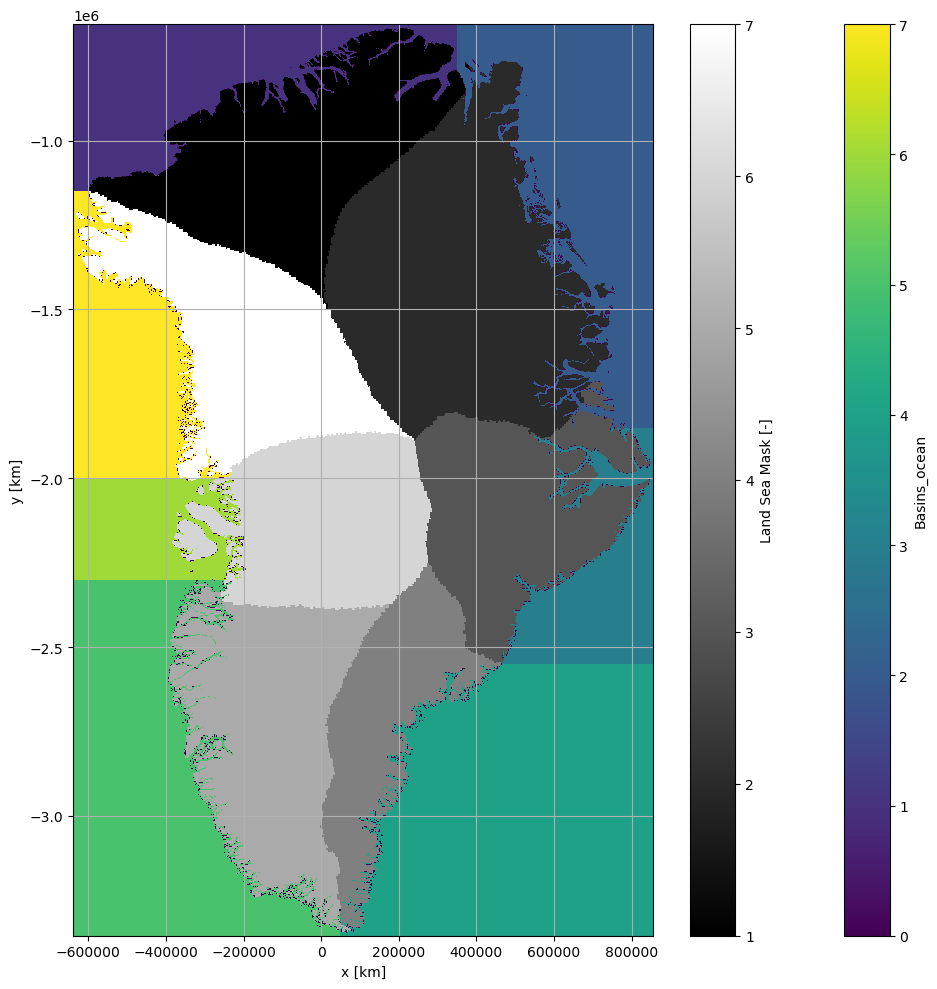

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))

xlim_min = 5e5
xlim_max = mask_1k_with_tundra.x.max()
ylim_min = -2.2e6
ylim_max = -1.5e6

# mask_1k_with_tundra['Basins_All_Greenland'].plot(robust=True, ax = ax, alpha=0.5, cmap='jet')

# make a variable that is only 0 
mask_1k_with_tundra['Basins_ocean'] = 1-  mask_1k_with_tundra['LSM']
mask_1k_with_tundra['Basins_ocean'] = mask_1k_with_tundra['Basins_ocean'].where(~(border_NE), 2)
mask_1k_with_tundra['Basins_ocean'] = mask_1k_with_tundra['Basins_ocean'].where(~(border_CE), 3)
mask_1k_with_tundra['Basins_ocean'] = mask_1k_with_tundra['Basins_ocean'].where(~(border_SE), 4)
mask_1k_with_tundra['Basins_ocean'] = mask_1k_with_tundra['Basins_ocean'].where(~(border_SW), 5)
mask_1k_with_tundra['Basins_ocean'] = mask_1k_with_tundra['Basins_ocean'].where(~(border_CW), 6)
mask_1k_with_tundra['Basins_ocean'] = mask_1k_with_tundra['Basins_ocean'].where(~(border_NW), 7)
mask_1k_with_tundra['Basins_ocean'] = mask_1k_with_tundra['Basins_ocean'].where(~(border_NO), 1)
mask_1k_with_tundra['Basins_ocean'] = mask_1k_with_tundra['Basins_ocean'].where(mask_1k_with_tundra['LSM'] ==0, 0)



# mask_1k_with_tundra['Basins_ocean'].where( (y>-2.55e6) & (x>0)).values = 3* mask_1k_with_tundra['Basins_ocean'].where( (y>-2.55e6) & (x>0)).values 

mask_1k_with_tundra['Basins_ocean'].plot(robust=True, ax = ax)
mask_1k_with_tundra['Basins_All_Greenland'].where(mask_1k_with_tundra['LSM']==1).plot(robust=True, ax = ax, cmap = 'gray')


# now show all area wher mask_1k_with_tundra['LSM'] ==0 and  border_CE_SE and border_CE_NE
# (mask_1k_with_tundra['LSM'].where((mask_1k_with_tundra['LSM'] == 0) & (border_CE_SE | border_CE_NE))).plot(robust=True, ax = ax, alpha=0.5, cmap='gray')

# now only plot y values above -2 1e6
plt.grid()
plt.tight_layout()



(array([2.0449e+04, 2.9280e+03, 1.5400e+03, 1.0450e+03, 7.2100e+02,
        5.3200e+02, 4.1900e+02, 3.3400e+02, 2.2000e+02, 2.2300e+02,
        1.7200e+02, 1.3800e+02, 1.0700e+02, 8.5000e+01, 7.9000e+01,
        5.4000e+01, 4.7000e+01, 4.3000e+01, 2.7000e+01, 4.1000e+01,
        2.5000e+01, 1.9000e+01, 1.5000e+01, 1.3000e+01, 1.6000e+01,
        1.7000e+01, 1.0000e+01, 9.0000e+00, 8.0000e+00, 1.0000e+01,
        1.0000e+01, 7.0000e+00, 8.0000e+00, 6.0000e+00, 1.2000e+01,
        5.0000e+00, 4.0000e+00, 4.0000e+00, 7.0000e+00, 7.0000e+00,
        5.0000e+00, 2.0000e+00, 4.0000e+00, 3.0000e+00, 3.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.00

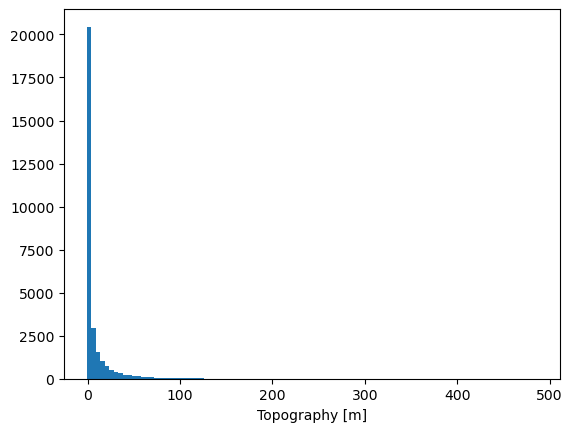

In [8]:
mask_1k_with_tundra
# find values in the mask where Basins_All_Greenland has a value and LSM is 0
# mask_1k_with_tundra['Topography'].where(mask_1k_with_tundra['Basins_All_Greenland'] == 0).plot()
# now make a histogram of the topography where Basins_All_Greenland has a value and LSM is 0
mask_1k_with_tundra['Topography'].where(mask_1k_with_tundra['Basins_All_Greenland'] == 0).plot.hist(bins=100)

# can  you make a mask for the dataset where Basins_All_Greenland has is 0# als

In [21]:
grid_size = "FGRN055"
downscaling_type = "Downscaling_GR"
time_resolution = "Annual"


path1k= os.path.join(path, grid_size, 
                              downscaling_type, time_resolution,
                             )

listFiles = []
for name in os.listdir(os.path.join(path)):
    listFiles.append(name)
listFiles = sorted(listFiles)
# Assuming listFiles is already populated with filenames
files_containing_runoff = []

for filename in listFiles:
    if "runoff" in filename:
        files_containing_runoff.append(filename)

print("Files containing'runoff':")

fpath_1k = os.path.join(path1k, files_containing_2018_runoff[0])


Files containing'runoff':


### Daily

In [23]:
dssnowfrac = xr.open_dataset("/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/2010/snowfrac.2010.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc")
file_dssnowfrac="/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/2010/snowfrac.2010.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc"


In [24]:
# Join the paths
path_daily1k = os.path.join(pathrapid, downscaling_type, time_resolution)

# Create a pattern for .nc and .gz files
pattern = os.path.join(path_daily1k, '**', '*.[ng]z')

# Use glob to find all files that match the pattern
files = glob.glob(pattern, recursive=True)

# Print the list of files
print(files)

['/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/precip.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/refreeze.1990-2020.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/runoff.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/smb_rec.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/sndiv.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/snowmelt.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/snowmelt.1990-2020.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/subl.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1k

In [25]:
pathMonthlylocal = "/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly"


In [26]:
# make directories for all years from 1989 to 2023 in 
path_monthly1k = "/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly"
for year in range(1989, 2024):
    os.makedirs(os.path.join(path_monthly1k, str(year)), exist_ok=True)

ds_snow_frac = xr.open_dataset("/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/2010/snowfrac.2010.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc")

In [69]:
ds_1k = xr.open_dataset(os.path.join(path, grid_size,   downscaling_type, "Annual", "runoff.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc"))

ds_1k.info()

xarray.Dataset {
dimensions:
	y = 2700 ;
	x = 1496 ;
	time = 30 ;

variables:
	float32 LAT(y, x) ;
		LAT:standard_name = Latitude ;
		LAT:long_name = Latitude ;
		LAT:units = Degree ;
		LAT:cell_methods = time: sum ;
		LAT:actual_range = [-3355.0962  -656.096 ] ;
	float32 LON(y, x) ;
		LON:standard_name = Longitude ;
		LON:long_name = Longitude ;
		LON:units = Degree ;
		LON:cell_methods = time: sum ;
		LON:actual_range = [-639.45605  855.54407] ;
	float32 runoffcorr(time, y, x) ;
		runoffcorr:standard_name = 1km_Topography_corrected_runoff ;
		runoffcorr:long_name = 1km Topography corrected runoff ;
		runoffcorr:units = mm w.e. per year ;
		runoffcorr:cell_methods = time: sum ;
		runoffcorr:actual_range = [ 0.       17.706615] ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
		time:long_name = time ;
		time:axis = T ;
	float32 x(x) ;
		x:long_name = x ;
		x:units = km ;
		x:axis = X ;
	float32 y(y) ;
		y:long_name = y ;
		y:units = km ;
		y:axis = Y ;

// global attributes

In [72]:
masks1k =  os.path.join(path, grid_size,   downscaling_type, "Icemask_Topo_Iceclasses_lon_lat_average_1km.nc")
masks1k = xr.open_dataset(masks1k, engine='netcdf4')
masks1k

<xarray.Dataset>
Dimensions:       (time: 1, x: 1496, y: 2700)
Coordinates:
  * time          (time) float32 0.0
  * x             (x) float32 5.0 10.0 15.0 20.0 ... 7.47e+03 7.475e+03 7.48e+03
  * y             (y) float32 5.0 10.0 15.0 20.0 ... 1.349e+04 1.35e+04 1.35e+04
Data variables:
    LON           (y, x) float32 ...
    LAT           (y, x) float32 ...
    Icemask       (y, x) float32 ...
    Promicemask   (y, x) float32 ...
    Topography    (y, x) float32 ...
    GrIS          (y, x) float32 ...
    GIC           (y, x) float32 ...
    grounded_ice  (y, x) float32 ...
    Easting       (y, x) float32 ...
    Northing      (y, x) float32 ...
Attributes:
    title:                      Daily Surface mass balance field (RACMO2.3)
    institution:                ULg (Xavier Fettweis)
    grid:                       Map Projection:Polar Stereographic Ellipsoid ...
    history:                    Mon Aug 10 13:33:00 2020: ncks -v Easting,Nor...
    netcdf:                     4.3.2 of Jan  5 2015 11:27:10 $
    NCO:                        netCDF Operators version 4.8.0 (Homepage = ht...
    history_of_appended_files:  Mon Aug 10 13:33:00 2020: Appended file GIMP_...

# ice mask 5.5 for greenland

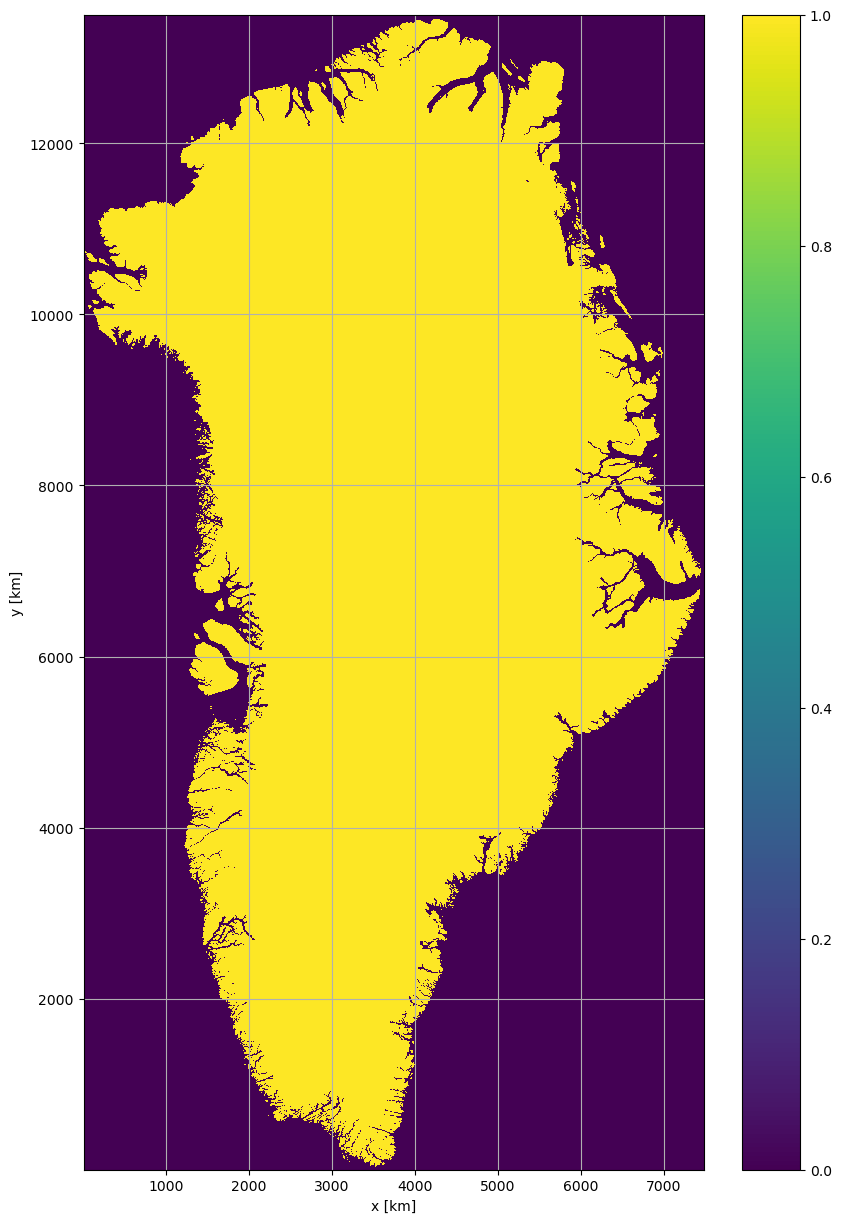

In [91]:

# CAN YOU MAKE A DATA ARRAY WITH 0 WHERE TOPOGRAPHY <1 AND 1 WHERE TOPOGRAPHY >1
elevation_threshold = 1 # m
topographyBinary = xr.where(((masks1k['Topography']>1) 
                             & ~((masks1k.x > 6000)&(masks1k.y>12000))),
                               1, 0)
fig, ax = plt.subplots(figsize = (10, 15))
masks1k['LSM'] =topographyBinary


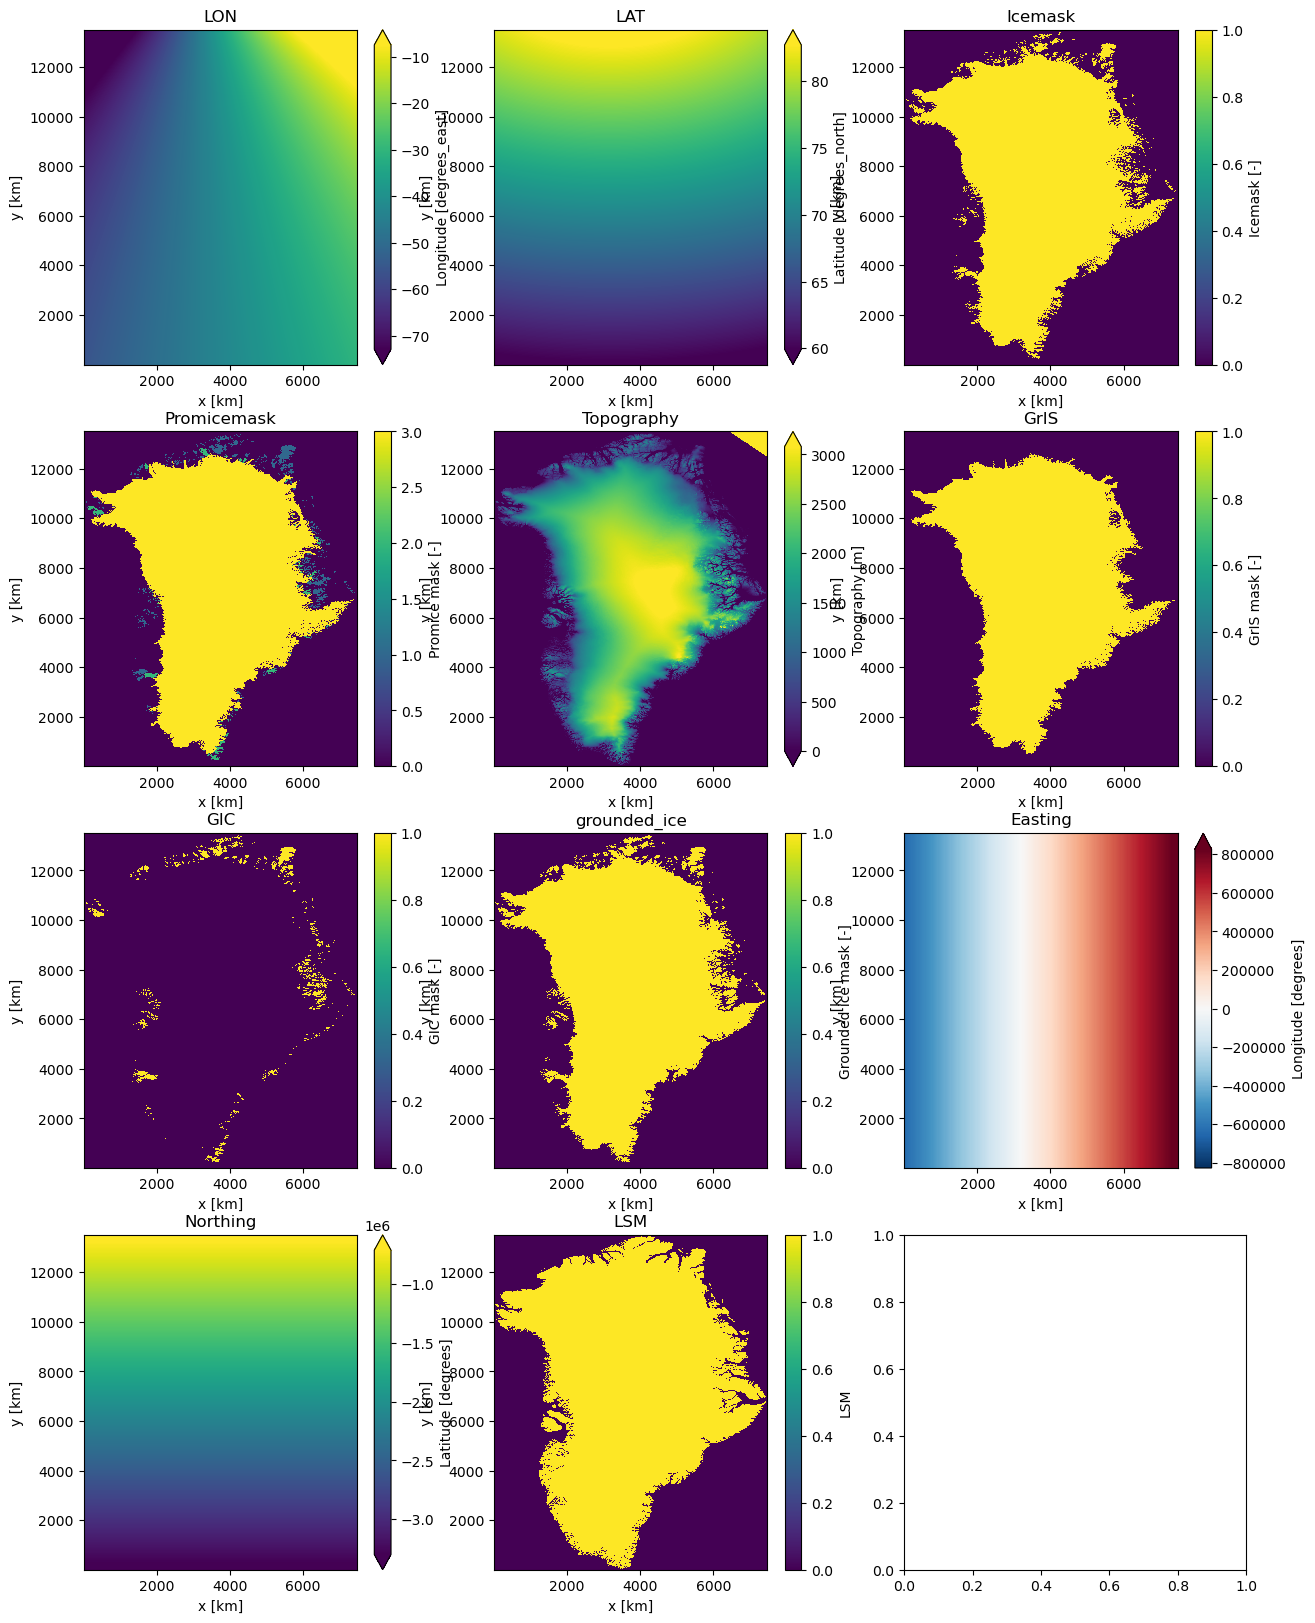

In [92]:
# plot all data variables in masks as a subplot
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
masks1k_vars = list(masks1k.data_vars)

for i, ax in enumerate(axs.flat):
    if i < len(masks1k_vars):
        masks1k[masks1k_vars[i]].plot(ax=ax, robust=True)
        ax.set_title(masks1k_vars[i])
# can you ad an ax with mask_vars['Topography'] >1 



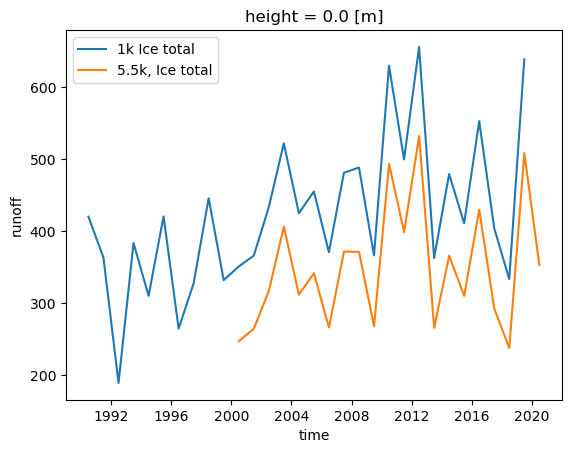

In [61]:
surface_area_per_gridcell = 1000**2
mm_weq_to_km3_1k = 1e-3 * surface_area_per_gridcell/1e9 # 1e-3 mm * 1e6 m2 , to km3

(ds_1k['runoffcorr'].where(masks1k['Promicemask'].values >= 1)*mm_weq_to_km3_1k).sum(dim=['x', 'y']).plot(label='1k Ice total')
(dss.runoff.where(masks['Promicemask'].values >= 2).sum(dim=['rlat', 'rlon'])*mm_weq_to_km3).plot(label='5.5k, Ice total')
plt.legend()


# Downscaled variables

In [27]:
!ls  "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055"


BN_RACMO2.3p2_ERA5_3h_FGRN055 GIMP_DEM_90m
Downscaling_GR                RACMO2.4.1_historical


In [28]:
from scripts.open_preprocess_racmo import *

In [107]:
path_annual_downscale = "/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/"
# list all files in path_annual_downscale and save them in list
import os


# List all files in the path and save them in a list
files = os.listdir(path_annual_downscale)

# Select all files that end with .nc
nc_files = [file for file in files if file.endswith(".gz")]
# Print the list of filenames
paths_nc_files = [path_annual_downscale + file for file in nc_files]
print(paths_nc_files)

# Print the list of files
vars_downscale = [file.split('.')[0] for file in nc_files]
print(vars_downscale)

['/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/precip.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/refreeze.1990-2020.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/runoff.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/smb_rec.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/sndiv.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/snowmelt.1990-2019.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz', '/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/snowmelt.1990-2020.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.

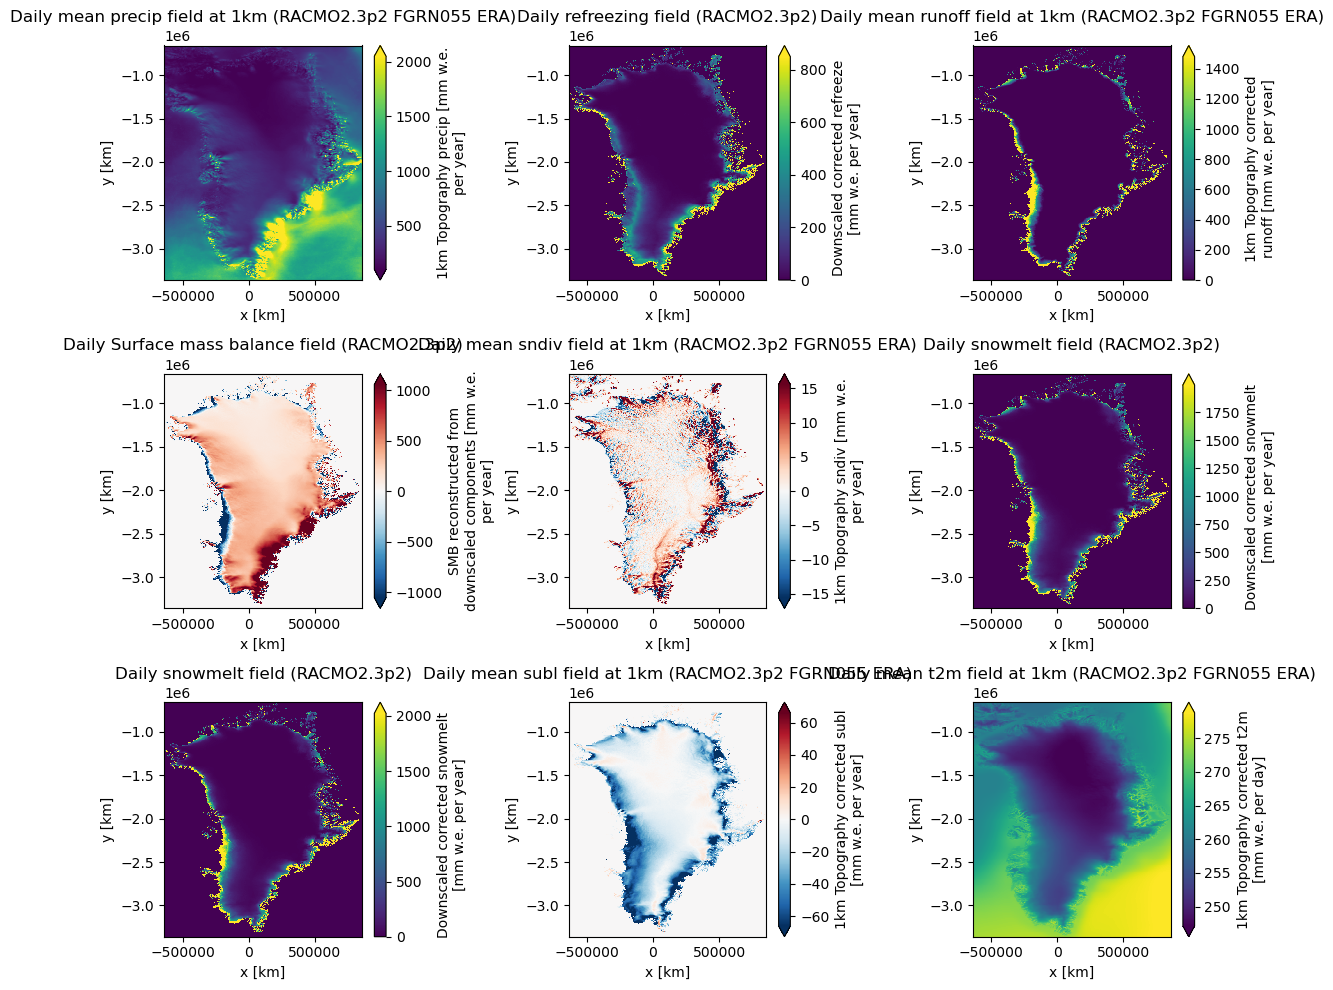

In [155]:
datavar = vars_downscale[0]
year = 2018

fig, axs = plt.subplots(3,3, figsize=[12,10])
for i, filename in enumerate(paths_nc_files):
    datavar = vars_downscale[i]
    ax = axs.flatten()[i]
    ds_downscale_var = xr.open_dataset(filename).sel(time=str(year))
    def find_corresponding_dsvar(datavar, ds):
        return [var for var in list(ds.data_vars) if var.startswith(datavar)][0]
    ds_downscale_var[find_corresponding_dsvar(datavar, ds_downscale_var)][::10, ::10].plot(robust=True, ax=ax)
    ax.set_title(ds_downscale_var.title)
plt.tight_layout()

# Calculated snow frac

In [102]:
xr.open_dataset("/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Daily/precip_v1.0/precip.2001_OND.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc.gz")

EOFError: Compressed file ended before the end-of-stream marker was reached

In [97]:
path_snowfrac = "/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/snowfrac.2-0.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc"
ds_snowfrac = xr.open_dataset(path_snowfrac)


<xarray.Dataset>
Dimensions:      ()
Data variables:
    precip_snow  float32 1.151e+04
    snowfrac     float32 0.9997

CPU times: user 90.9 ms, sys: 10.9 ms, total: 102 ms
Wall time: 102 ms


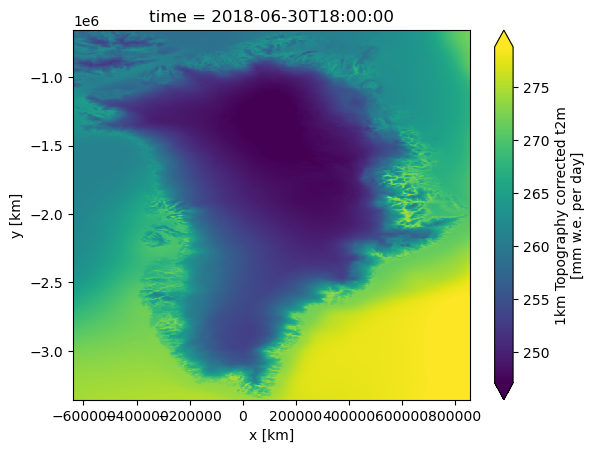

In [152]:
%%time
# select every second x and y
ds_downscale_var[find_corresponding_dsvar(datavar, ds_downscale_var)][::5, ::5].plot(robust=True)

In [159]:
ds_snowfrac = xr.open_dataset("/Volumes/science/projects/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Daily/snowfrac/snowfrac.2021_OND.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.nc.gz")

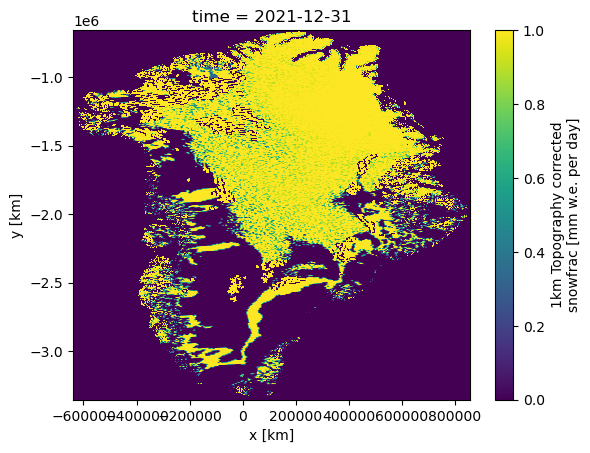

In [166]:
ds_snowfrac['snowfraccorr'].isel(time=-1).plot(robust=True)

In [68]:
from scripts.open_preprocess_racmo import read_RACMO
read_RACMO("1k", "Monthly", ['2010'], "precip")

 it might be hard to process the data for the whole period, please be patient, or choose a lower time resolution or spatial resolution


<xarray.Dataset>
Dimensions:     (y: 2700, x: 1496, time: 12)
Coordinates:
  * time        (time) datetime64[ns] 2010-01-16 ... 2010-12-16
  * x           (x) float32 -6.39e+05 -6.38e+05 -6.37e+05 ... 8.55e+05 8.56e+05
  * y           (y) float32 -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
Data variables:
    LAT         (y, x) float32 ...
    LON         (y, x) float32 ...
    precipcorr  (time, y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  IMAU (Brice Noel)
    title:        Daily mean precip field at 1km (RACMO2.3p2 FGRN055 ERA)
    grid:         Map Projection:Polar Stereographic Ellipsoid - Map Referenc...
    netcdf:       4.7.4 of Apr 18 2020 10:56:44 $
    frequency:    mon
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...

In [71]:
ds_precip.time.groupby('time.month').mean()

<xarray.DataArray 'time' (month: 3)>
array(['2010-01-16T00:00:00.000000000', '2010-02-14T12:00:00.000000000',
       '2010-03-16T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * month    (month) int64 1 2 3
Attributes:
    long_name:      time
    standard_name:  time

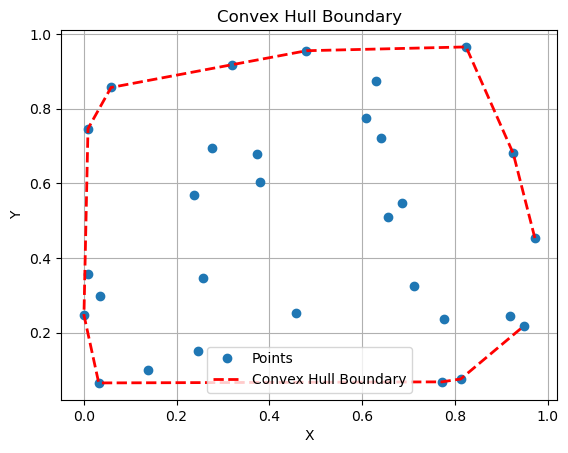